![](/images/blog/dotafriends.png)

What better way is there to enjoy games than with friends? Of course, some friends have better synergies than others. What if there was a way to quantify those synergies and draw a group of friends as a graph, with high-synergy friends placed close together and low-synergy friends placed further apart?

In this post, we'll use the [OpenDota API](https://docs.opendota.com/), [multidimensional scaling (MDS)](https://en.wikipedia.org/wiki/Multidimensional_scaling), and [networkx](https://networkx.github.io/) to visualize a network of friends playing Dota 2 together.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gilgi/gilgi.github.com/blob/src/posts/dotafriends.ipynb)

<!-- TEASER_END -->

In [0]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.manifold import MDS

Here's our list of friends with their yasp account id's:

In [0]:
name_to_id = {
    'gilgi': 30545806,
    'mark': 60514096,
    'nd': 34814716,
    'tritz': 63826936,
    'sehi': 59311372,
    'vindi': 37784737,
    'kwint': 47374215,
    'boomsy': 14046169,
    'janus': 59053168
}
names, account_ids = zip(*name_to_id.items())
n = len(names)

Here's a function that hits the yasp API and gets the win-loss record for a particular player, constraining the results to only those matches that include and exclude certain other players.

In [0]:
def get_winrate(account_id, included_account_ids, excluded_account_ids):
    base_url = 'https://api.opendota.com/api/players/%s/wl' % account_id
    query_string = '&'.join(['included_account_id=%s' % i
                             for i in included_account_ids] +
                            ['excluded_account_id=%s' % i
                             for i in excluded_account_ids])
    complete_url = base_url + '?' + query_string
    win_lose = requests.get(complete_url).json()
    if win_lose['lose'] and win_lose['win']:
        winrate = win_lose['win'] / (win_lose['win'] + win_lose['lose'])
    else:
        winrate = np.nan
    return winrate

Based on this, we will define solo winrate as the winrate a player has when none of the other friends in our list is in the game. This isn't strictly guaranteed to only include solo queue games (since the player could have just queued with someone not in our list of friends), but for our purposes this is still a good definition.

In [0]:
def get_solo_winrate(account_id):
    return get_winrate(account_id, [], set(name_to_id.values()) - {account_id})

We can test out this function to get the winrate for one specific player (ouch):

In [0]:
get_solo_winrate(name_to_id['gilgi'])

0.4444444444444444

Based on the same `get_winrate()` function we can also define pair winrate as the winrate two players have when they are both in the game and no other friend in our list is in the game.

In [0]:
def get_pair_winrate(account_id_a, account_id_b):
    return get_winrate(account_id_a, [account_id_b],
                       set(name_to_id.values()) - {account_id_a, account_id_b})

We can test out this function to get the winrate for one specific pairing:

In [0]:
get_pair_winrate(name_to_id['gilgi'], name_to_id['vindi'])

0.5857142857142857

Now that we have the basic data-collecting functions in place, we can collect a vector of all the solo winrates:

In [0]:
solo_winrate = np.array([get_solo_winrate(i) for i in account_ids])

We can sort players by solo winrate and plot a barplot:

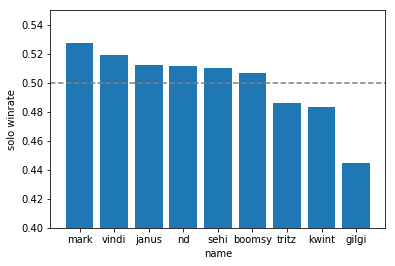

In [0]:
sort_idx = np.argsort(solo_winrate)[::-1]
plt.bar(np.array(names)[sort_idx], solo_winrate[sort_idx])
xmin, xmax = plt.xlim()
plt.hlines(0.5, xmin, xmax, color='gray', linestyles='--')
plt.xlim((xmin, xmax))
plt.ylim((0.4, 0.55))
plt.xlabel('name')
plt.ylabel('solo winrate');

Next, we can collect a matrix of the pair winrates. This matrix should be symmetric so we will save on API calls and copy entries from the lower triangle to the upper triangle. We will write the solo winrate on the diagonal of this matrix.

In [0]:
pair_winrate = np.zeros((n, n))
for i in range(n):
    for j in range(i):
        pair_winrate[i, j] = get_pair_winrate(account_ids[i], account_ids[j])
        pair_winrate[j, i] = pair_winrate[i, j]
np.fill_diagonal(pair_winrate, solo_winrate)

We can visualize all the pair winrates as a heatmap:

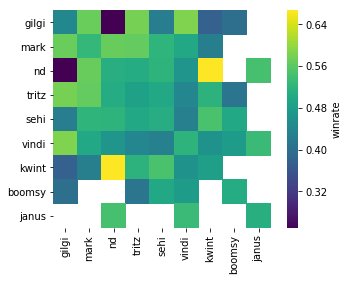

In [0]:
sns.heatmap(pair_winrate, cmap='viridis', square=True,
            xticklabels=names, yticklabels=names, cbar_kws={'label': 'winrate'})

The outliers here are the nd x kwint pairing, which has [only 9 significant games](https://www.opendota.com/players/47374215?included_account_id=34814716&excluded_account_id=59053168&excluded_account_id=60514096&excluded_account_id=14046169&excluded_account_id=37784737&excluded_account_id=30545806&excluded_account_id=63826936&excluded_account_id=59311372), and the nd x gilgi pairing which has [12 significant games](https://www.opendota.com/players/30545806?excluded_account_id=59053168&excluded_account_id=14046169&excluded_account_id=60514096&excluded_account_id=47374215&excluded_account_id=37784737&excluded_account_id=59311372&excluded_account_id=63826936&included_account_id=34814716). We could be more strict about which pairings we want to include (e.g., enforcing at least 10 matches), but this is fine for now.

Next, we can compute the difference between a player's solo winrate and their pair winrate with every other player. We will call this a "winrate delta". This is not symmetric - the player whose winrate is changing will be in the rows of this matrix, and the player who they play with to achieve that winrate change will be in the columns of this matrix.

In [0]:
winrate_delta = pair_winrate - solo_winrate[:, None]

We can plot this matrix as a heatmap too:

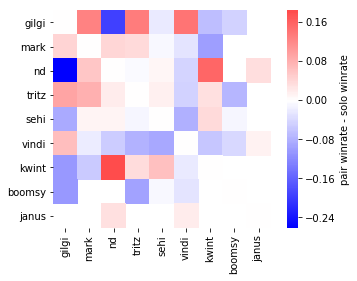

In [0]:
sns.heatmap(winrate_delta, cmap='bwr', square=True, center=0,
            xticklabels=names, yticklabels=names,
            cbar_kws={'label': 'pair winrate - solo winrate'})

Next, we want to construct a distance matrix among all the players. This should probably be symmetric, positive, and have zeros on the diagonal. We mentioned that the winrate matrix is not symmetric, but we can symmetrize it by averaging it with its transpose. This symmetric version of the matrix should be the same thing as "pairwise winrate - average solo winrate of the two players".

In [0]:
winrate_sym = (winrate_delta + winrate_delta.T) / 2
assert np.allclose(winrate_sym, winrate_sym.T, equal_nan=True)

We can then make it positive by subtracting the max and flipping the sign (so that the largest distances correspond to players who play worst when together), then we can add a constant to enforce a minimum distance, and fill the diagonal with zeros:

In [0]:
winrate_dist = -(winrate_sym - np.nanmax(winrate_sym))
assert np.all((winrate_dist >= 0) | np.isnan(winrate_dist))
min_dist = np.nanpercentile(winrate_dist[np.triu_indices(n)], 10)
winrate_dist += min_dist
np.fill_diagonal(winrate_dist, 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


Some pairs of players have missing winrate data, so for now we will impute in the median nonzero distance as a guess of their distances. This is a bit suboptimal because players like janus that have lots of missing data will be pushed to be equidistant from all other players (effectively the center of a circle).

In [0]:
winrate_dist_impute = winrate_dist.copy()
median_dist = np.median(
    list(filter(lambda x: x > 0, list(winrate_dist[np.triu_indices(n)]))))
winrate_dist_impute[np.isnan(winrate_dist_impute)] = median_dist

We can now attempt to embed the players in a 2-dimensional space based on these distances using multidimensional scaling

In [0]:
mds = MDS(dissimilarity='precomputed', n_init=100, random_state=42)
coords = mds.fit_transform(winrate_dist_impute)

We can plot this as a scatterplot:

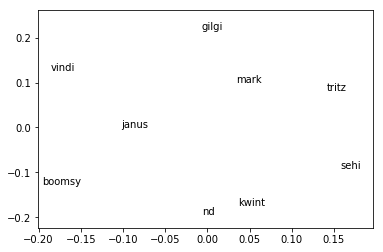

In [0]:
plt.scatter(coords[:, 0], coords[:, 1], color='white')
for i in range(n):
    plt.annotate(names[i], (coords[i, 0], coords[i, 1]), va='center',
                 ha='center')

We can also draw this as a graph:

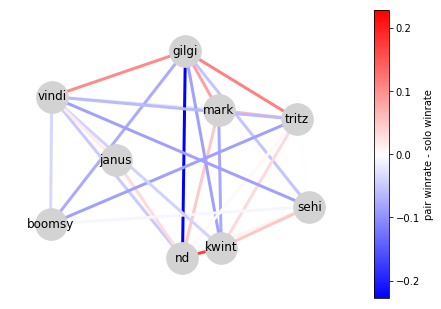

In [0]:
g = nx.Graph()
for i in range(n):
    for j in range(i):
        if np.isfinite(winrate_dist[i, j]):
            g.add_edge(names[i], names[j], weight=winrate_sym[i, j])
weights = [e[2]['weight'] for e in g.edges.data()]
max_abs_weight = np.nanmax(np.abs(weights))
cmap = 'bwr'
sm = plt.cm.ScalarMappable(
    norm=plt.Normalize(vmin=-max_abs_weight, vmax=max_abs_weight), cmap=cmap)
sm.set_array(weights)
nx.draw(g, dict(zip(names, coords)), edge_color=sm.to_rgba(weights), width=3,
        node_size=1000, node_color='lightgray', with_labels=True)
plt.colorbar(sm, label='pair winrate - solo winrate');